In [13]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# PostgreSQL bağlantı bilgileri
db_params = {
    'dbname': 'ecommerce_data',
    'user': 'postgres',
    'password': *********,
    'host': 'localhost',
    'port': '5432'
}

In [19]:
# SQLAlchemy bağlantı URL'si
db_url = f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}"

# SQLAlchemy engine oluşturma
engine = create_engine(db_url)

Veri başarıyla çekildi!


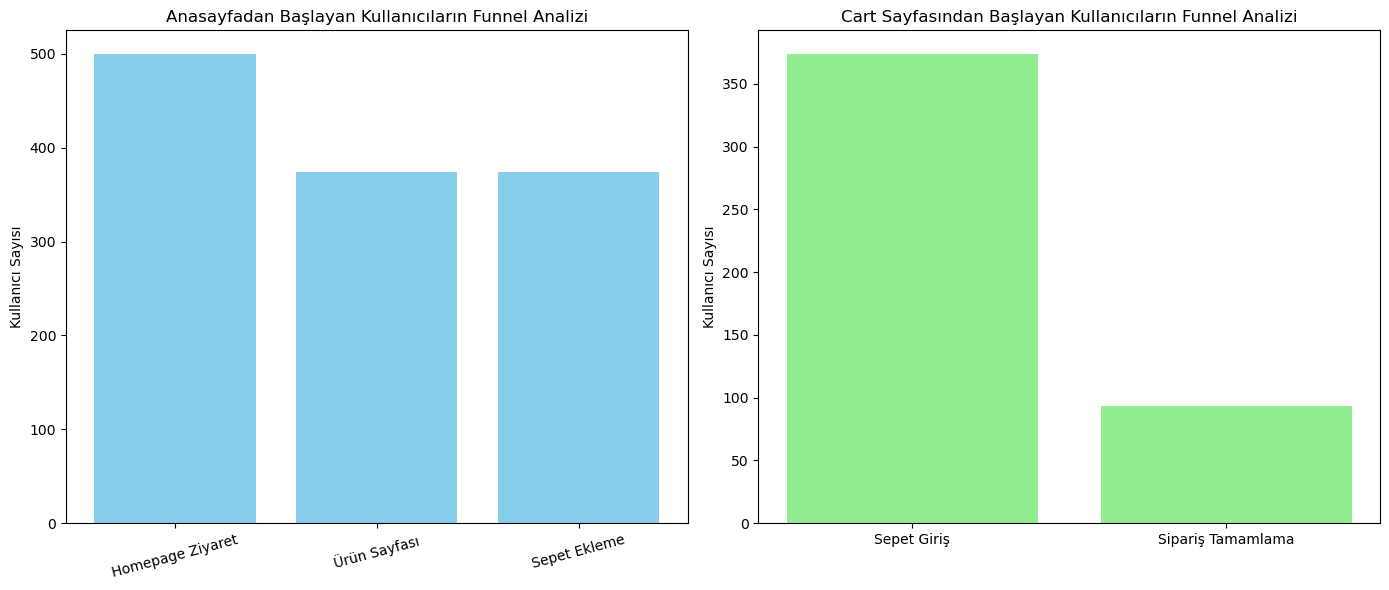

In [21]:
homepage_query = """
    SELECT 
        COUNT(DISTINCT visitor_id) AS homepage_visitors,
        COUNT(DISTINCT CASE WHEN page = 'product_page' THEN visitor_id END) AS product_page_visitors,
        COUNT(DISTINCT CASE WHEN page = 'cart' THEN visitor_id END) AS cart_visitors
    FROM page_visits2
    WHERE page = 'homepage' OR page = 'product_page' OR page = 'cart';
"""

cart_query = """
    SELECT 
        COUNT(DISTINCT pv.visitor_id) AS cart_visitors,
        COUNT(DISTINCT o.visitor_id) AS order_completers
    FROM page_visits2 pv
    LEFT JOIN orders2 o ON pv.visitor_id = o.visitor_id
    WHERE pv.page = 'cart';
"""

try:
    # SQL sorgularını çalıştır ve DataFrame'e yükle
    homepage_data = pd.read_sql_query(homepage_query, engine)
    cart_data = pd.read_sql_query(cart_query, engine)
    
    print("Veri başarıyla çekildi!")

    # Funnel verilerini düzenle
    homepage_funnel = {
        "Aşama": ["Homepage Ziyaret", "Ürün Sayfası", "Sepet Ekleme"],
        "Kullanıcı Sayısı": [
            homepage_data['homepage_visitors'][0],
            homepage_data['product_page_visitors'][0],
            homepage_data['cart_visitors'][0]
        ]
    }
    
    cart_funnel = {
        "Aşama": ["Sepet Giriş", "Sipariş Tamamlama"],
        "Kullanıcı Sayısı": [
            cart_data['cart_visitors'][0],
            cart_data['order_completers'][0]
        ]
    }
    
    # DataFrame oluştur
    homepage_df = pd.DataFrame(homepage_funnel)
    cart_df = pd.DataFrame(cart_funnel)

    # Görselleştirme
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Anasayfadan başlayan funnel
    axes[0].bar(homepage_df["Aşama"], homepage_df["Kullanıcı Sayısı"], color="skyblue")
    axes[0].set_title("Anasayfadan Başlayan Kullanıcıların Funnel Analizi")
    axes[0].set_ylabel("Kullanıcı Sayısı")
    axes[0].tick_params(axis='x', rotation=15)

    # Cart'tan başlayan funnel
    axes[1].bar(cart_df["Aşama"], cart_df["Kullanıcı Sayısı"], color="lightgreen")
    axes[1].set_title("Cart Sayfasından Başlayan Kullanıcıların Funnel Analizi")
    axes[1].set_ylabel("Kullanıcı Sayısı")

    # Grafik gösterimi
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Hata:", e)

# Sonuçların Yorumlanması

- **Anasayfadan Başlayan Kullanıcılar:**

1. Homepage Ziyaret: Yaklaşık 500 kullanıcı anasayfayı ziyaret etmiş.
   
2. Ürün Sayfası: 370-380 kullanıcı ürün sayfasına ilerlemiş.
    - Bu noktada 120 kullanıcı kaybedilmiş (**%24 drop-off**).

3. Sepet Ekleme: Kullanıcı sayısı ürün sayfasıyla hemen hemen aynı (370-380).
    - Ürün sayfasına geçen kullanıcıların büyük bir kısmı ürünü sepete eklemiş.
      
**Özet:**
Anasayfadan başlayan kullanıcılar için drop-off en çok homepage → ürün sayfası geçişinde yaşanmış.

- Burada:
    - Site tasarımı veya ürün görünürlüğü etkili olabilir.
    - Kullanıcıları ürün sayfasına yönlendiren banner veya linklerin performansı değerlendirilmeli.




- **Card Sayfasından Başlayan Kullanıcılar:**
1. Sepet Giriş: 370 kullanıcı doğrudan sepete girmiş.

2. Sipariş Tamamlama: Yaklaşık 90 kullanıcı sipariş tamamlamış.

    - Burada 280 kullanıcı kaybedilmiş (%75 drop-off).

**Özet:**
- Sepetten siparişe geçişte çok büyük bir kayıp var.
- Bu aşamada:
    - Ödeme sayfasındaki sorunlar (örneğin: teknik hatalar, karmaşık ödeme formu).
    - Ek maliyetler (kargo ücreti, vergi vb.) olabilir.

# Öneriler ve Aksiyon Adımları 🚀
1. **Homepage → Ürün Sayfası Geçişini İyileştirme:**

    - Ürün önerileri, popüler ürünler veya kampanyalar daha görünür hale getirilmeli.
    - A/B testleri ile banner performansını değerlendirebiliriz.
2. **Sepet → Sipariş Tamamlama Kayıplarını Azaltma:**

    - Sepet aşamasında kullanıcı davranışlarını incele:
        - Kargo ücretini önceden göster.
        - Basit ödeme seçenekleri ekle.
    -Exit-Intent Popup kullanarak kullanıcıyı geri kazan.
3. **A/B Testleri Yaparak Performans Ölçümü:**

    - Funnel aşamalarındaki değişiklikleri A/B testleri ile analiz edip etkisini ölç.